In [ ]:

import os, warnings, joblib, torch, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model   import LogisticRegression
from sklearn.metrics        import classification_report, confusion_matrix
from sklearn.preprocessing  import LabelEncoder
from sklearn.utils          import resample
import seaborn as sns, matplotlib.pyplot as plt
from torch.utils.data       import Dataset, DataLoader
from transformers           import AutoTokenizer, AutoModelForSequenceClassification

warnings.filterwarnings("ignore")

#Paths
BASE = "Project/Models"
PATHS = {
    "LR":   dict(model=f"{BASE}/Baseline_Multiclass/logreg_tfidf_model.joblib",
                 vec  =f"{BASE}/Baseline_Multiclass/tfidf_vectorizer.joblib"),
    "SVM":  dict(model=f"{BASE}/SVM_Multiclass/emotion_svm_classifier.joblib",
                 vec  =f"{BASE}/SVM_Multiclass/tfidf_vectorizer.joblib"),
    "XGB":  dict(model=f"{BASE}/XGboost/xgb_model.joblib",
                 vec  =f"{BASE}/XGboost/xgb_vectorizer.joblib"),
    "TRANSFORMER_DIR": f"{BASE}/RoBERTa_Multiclass"
}

#Hyper-params
MAX_LEN, BATCH, FOLDS = 128, 16, 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Dataset
df = (pd.read_csv("Project/reddit_labeled.csv")[["clean_text", "label"]]
        .dropna().reset_index(drop=True))

LABELS = ["neutral",
          "academic_stress",
          "relationship_issues",
          "existential_crisis",
          "social_isolation"]                       # canonical order
df = df[df.label.isin(LABELS)]

#class-balance (down-sample every label to the minority count)
min_n  = df.label.value_counts().min()
df_bal = (pd.concat([resample(df[df.label == lab],
                              n_samples=min_n,
                              replace=False,
                              random_state=42)
                     for lab in LABELS])
            .sample(frac=1, random_state=42)
            .reset_index(drop=True))

X, y  = df_bal.clean_text.astype(str).values, df_bal.label.values
NUM_CLASSES  = len(LABELS)
LBL_ENCODER  = LabelEncoder().fit(LABELS)           # ↔ ints helper

#train / test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#load classical learners
vec_lr,  lr_clf  = joblib.load(PATHS["LR"]["vec"]),  joblib.load(PATHS["LR"]["model"])
vec_svm, svm_clf = joblib.load(PATHS["SVM"]["vec"]), joblib.load(PATHS["SVM"]["model"])
vec_xgb, xgb_clf = joblib.load(PATHS["XGB"]["vec"]), joblib.load(PATHS["XGB"]["model"])

#Robust column-re-order (always 2-D)
def reorder_cols(prob_matrix, model_classes):
    """
    Return a (n_samples, NUM_CLASSES) matrix whose columns follow LABELS.
    Any class missing from `model_classes` is filled with zeros.
    Works whether model_classes are strings or integer ids.
    """
    # Convert integer ids (canonical label names if needed)
    if not isinstance(model_classes[0], str):
        model_classes = LBL_ENCODER.inverse_transform(model_classes)

    col_map = {lab: idx for idx, lab in enumerate(model_classes)}

    out = np.zeros((prob_matrix.shape[0], NUM_CLASSES), dtype=np.float32)
    for col_idx, lab in enumerate(LABELS):
        if lab in col_map:                      # present → copy column
            out[:, col_idx] = prob_matrix[:, col_map[lab]]
        # else keep zeros (class unseen by this model)

    return out                                  # always 2-D (n, NUM_CLASSES)

#transformer (RoBERTa)
tok = AutoTokenizer.from_pretrained(PATHS["TRANSFORMER_DIR"])
txf = AutoModelForSequenceClassification.from_pretrained(
        PATHS["TRANSFORMER_DIR"],
        num_labels=NUM_CLASSES).to(DEVICE).eval()

class TxtSet(Dataset):
    def __init__(self, texts): self.texts = texts
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = tok(self.texts[i], truncation=True, padding="max_length",
                  max_length=MAX_LEN, return_tensors="pt")
        return {k: v.squeeze() for k, v in enc.items()}

def transformer_probs(text_arr):
    loader, all_p = DataLoader(TxtSet(text_arr), batch_size=BATCH), []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            all_p.append(torch.softmax(txf(**batch).logits, dim=1).cpu().numpy())
    return np.vstack(all_p)

#build OOF meta-features
COLS_PER_MODEL, N_MODELS = NUM_CLASSES, 4
meta_train = np.zeros((len(X_tr), COLS_PER_MODEL * N_MODELS))
skf        = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for tr_idx, val_idx in skf.split(X_tr, y_tr):
    X_val = X_tr[val_idx]

    meta_train[val_idx, 0*NUM_CLASSES:1*NUM_CLASSES] = \
        reorder_cols(lr_clf.predict_proba (vec_lr .transform(X_val)), lr_clf.classes_)

    meta_train[val_idx, 1*NUM_CLASSES:2*NUM_CLASSES] = \
        reorder_cols(svm_clf.predict_proba(vec_svm.transform(X_val)), svm_clf.classes_)

    meta_train[val_idx, 2*NUM_CLASSES:3*NUM_CLASSES] = \
        reorder_cols(xgb_clf.predict_proba(vec_xgb.transform(X_val)), xgb_clf.classes_)

    meta_train[val_idx, 3*NUM_CLASSES:4*NUM_CLASSES] = \
        transformer_probs(X_val)

#meta learner
meta_clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_clf.fit(meta_train, y_tr)

#test-time meta-matrix
test_meta = np.hstack([
    reorder_cols(lr_clf .predict_proba(vec_lr .transform(X_te)), lr_clf.classes_),
    reorder_cols(svm_clf.predict_proba(vec_svm.transform(X_te)), svm_clf.classes_),
    reorder_cols(xgb_clf.predict_proba(vec_xgb.transform(X_te)), xgb_clf.classes_),
    transformer_probs(X_te)
])

meta_preds = meta_clf.predict(test_meta)

print("\n  Stacked Ensemble (LR | SVM | XGB | RoBERTa) – Classification Report\n")
print(classification_report(y_te, meta_preds, target_names=LABELS, digits=4))

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



  Stacked Ensemble (LR | SVM | XGB | RoBERTa) – Classification Report

                     precision    recall  f1-score   support

            neutral     1.0000    1.0000    1.0000        12
    academic_stress     1.0000    0.9167    0.9565        12
relationship_issues     0.8333    0.8333    0.8333        12
 existential_crisis     0.7333    0.8462    0.7857        13
   social_isolation     1.0000    0.9167    0.9565        12

           accuracy                         0.9016        61
          macro avg     0.9133    0.9026    0.9064        61
       weighted avg     0.9104    0.9016    0.9044        61



In [7]:
!pip install seaborn
!pip install transformers
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 25.4 MB/s eta 0:00:00:00:0100:01


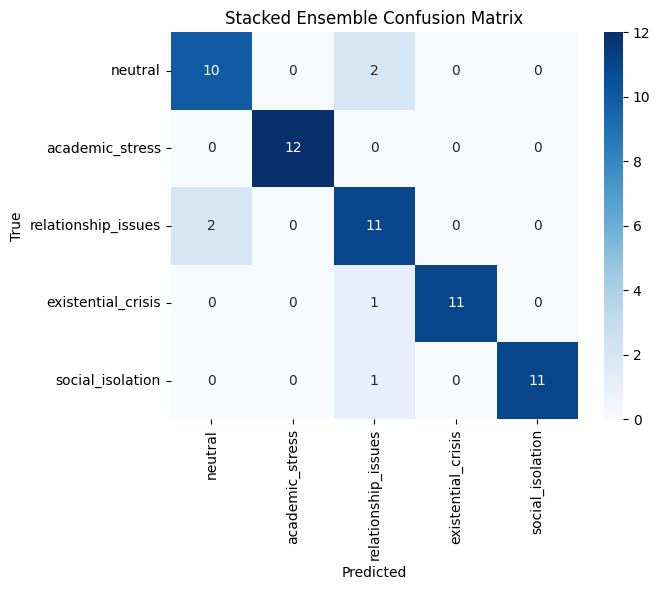


  Meta-classifier & paths stored in  Project/Models/Stacked_XGB


In [3]:
#confusion-matrix
cm = confusion_matrix(y_te, meta_preds, labels=LABELS)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Stacked Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

#save artefacts
SAVE_DIR = f"{BASE}/Stacked_XGB"
os.makedirs(SAVE_DIR, exist_ok=True)
joblib.dump(meta_clf, f"{SAVE_DIR}/meta_classifier.joblib")
joblib.dump(PATHS,    f"{SAVE_DIR}/base_paths.joblib")
print(f"\n  Meta-classifier & paths stored in  {SAVE_DIR}")